## Environment setup 🏛


In [1]:
! pip install python-dotenv
! pip install monai
! pip install shutil

import os
import sys
from google.colab import drive


import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import tarfile
import nibabel as nib
import glob
import random
import shutil
import time
from distutils.dir_util import copy_tree

from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler

from monai.losses import DiceCELoss, DiceFocalLoss, DiceLoss, FocalLoss

drive.mount('/content/drive/')

torch.cuda.empty_cache()
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Using cuda device


In [2]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/.env' ]; then
    echo "Creating .env file..."
    echo "INPUT_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'" > '/content/drive/MyDrive/Lorusso/BraTS/.env'
    echo "PROCESSED_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/processed'" >> '/content/drive/MyDrive/Lorusso/BraTS/.env'
fi

In [3]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar'  ]; then
    echo "Downloading BraTS dataset at /content/drive/MyDrive/Lorusso/BraTS/data/raw ..."
    mkdir /root/.kaggle/
    cp '/content/drive/MyDrive/Lorusso/kaggle.json' /root/.kaggle
    chmod 600 '/root/.kaggle/kaggle.json'
    cd '/content/drive/MyDrive/Lorusso/BraTS/data/raw' && kaggle datasets download -d dschettler8845/brats-2021-task1
    ls '/content/drive/MyDrive/Lorusso/BraTS/data/raw'
    unzip '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip' -d '/content/drive/MyDrive/Lorusso/BraTS/data/raw/'
    rm -r '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip'
fi

In [4]:
%%bash
rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled
if [ ! -d '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled' ]; then
      mkdir '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'
fi

path='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'
dst='/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/'

for el in $(ls $path | head -n 10);
do
    echo "$path/$el -> $dst"
    cp -R "$path/$el" $dst
done


/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00000 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00002 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00003 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00005 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00006 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00008 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00009 -> /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/
/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats/BraTS2021_00011 -> /content/drive/MyDr

## Utils 🛠

In [5]:
def untar_brats(tar_path, extract_path):
    tar = tarfile.open(tar_path)
    tar.extractall(extract_path)
    tar.close()


def plot_brain_sections(images,ax = 1,slice_index = 90):

    """
    """

    d1,d2,d3 = np.shape(images[1])
    dims = [d1,d2,d3]
    dims.pop(ax)
    color_segmentation = np.zeros((dims[0],dims[1],3))

    gray_segmentation = np.take(images[1],slice_index,axis = ax)
    color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
    color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
    color_segmentation[gray_segmentation == 4] = [0,0,255] # Blue (enhancing tumor)

    t1 = images[0][0]
    flair = images[0][1]
    t2 = images[0][2]
    t1ce = images[0][3]

    image = t1+t2+flair+t1ce

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.take(image,slice_index,axis = 0),cmap='gray')

    plt.subplot(1,4,2)
    plt.imshow(np.take(image,slice_index,axis = 1),cmap='gray')

    plt.subplot(1,4,3)
    plt.imshow(np.take(image,slice_index,axis = 2),cmap='gray')

    plt.subplot(1,4,4)
    plt.imshow(color_segmentation,cmap='gray')
    plt.xlabel('Segmentation')

## Dataset class  💾


In [6]:
'''
Preprocessing script to convert from data provided by BraTS to data used by our model. Should be the first thing you run.
Fulfills the following four functions:
1. Normalize and standardize each image of each MRI modality
2. Combine multiple MRI modalitities into one image array
3. Swap labels from BraTS order (0,2,1,4) to more intuitive order (0,1,2,3)
4. Convert image into a graph
    Using Simple Linear Iterative Clustering algorithm
    Parameters passed on command line

If no labels are present (e.g. at test time, in deployment) can also build graph without labels.

Saves the following in the specified output directory for each sample
MRI_ID/
    _input.nii.gz (processed and combined modalities for a sample as nifti file)
    _label.nii.gz
    _nxgraph.json (networkx graph containing both graph topography and features and labels for each node)
    _supervoxels.nii.gz (supervoxel partitioning produced by SLIC)
    _crop.npy (optionally the crop of the processed data relative to the original data) (crops out empty image planes)
'''


class DataPreprocessor(Dataset):
  def __init__(self, dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env", transform = True, INPUT_PATH = None):

    load_dotenv(dotenv_path)
    # Data mean and variance
    data_stats = ([0.4645, 0.6625, 0.4064, 0.3648], [0.1593, 0.1703, 0.1216, 0.1627])

    if(INPUT_PATH is not None and os.path.exists(INPUT_PATH)):
        self.data_dir = INPUT_PATH
    else:
        self.data_dir = os.getenv('INPUT_DATA_DIR')
    self.output_dir = os.getenv('PROCESSED_DATA_DIR')
    self.mri_prefix = 'BraTS2021'
    self.modality_extensions = ["_flair.nii.gz", "_t1.nii.gz", "_t1ce.nii.gz", "_t2.nii.gz"]
    self.label_extension = "_seg.nii.gz"
    self.include_labels = self.label_extension is not None
    self.all_ids, self.id_to_fp = self.get_all_mris_in_dataset()
    self.LABEL_MAP = {4: 3, 2: 1, 1: 2}
    self.dataset_mean = np.array(data_stats[0], dtype=np.float32)
    self.dataset_std = np.array(data_stats[1], dtype=np.float32)
    self.transform = transform if isinstance(transform, bool) else True


  def __len__(self):
    return len(self.all_ids)


  def __getitem__(self,idx):
    images = []
    # Load the image corresponding to idx
    try:
      fp = [self.id_to_fp[k] for k in self.all_ids if k.split('_')[-1] == idx][0]
      bn = os.path.basename(os.path.split(fp)[0])
      images.append([nib.load(os.path.join(fp, bn + level)).get_fdata(dtype=np.float32).T
                     for level in self.modality_extensions])
      labels = nib.load(os.path.join(fp, bn + self.label_extension)).get_fdata(dtype=np.float32).T

      # Convert to numpy array otherwise you'll experience RAM leak
      images = np.asarray(images[0])
      imstack = np.stack(np.array(images, dtype=np.float32), axis = 0)
      imstack, labels = self.padding(imstack, labels)

      if (self.transform):
          imstack,labels = self.get_standardized_image(imstack, labels)

    except Exception as e:
      print(f"Exception thrown in class {self.__class__.__name__ }, method __getitem__")
      print(e)
      imstack = np.zeros([4,240,240,240],dtype=np.float32)
      labels = np.zeros([240, 240, 240])

    return np.array(imstack), labels


  def get_all_mris_in_dataset(self):
    mri_folders = glob.glob(f"{self.data_dir}**/{self.mri_prefix}*/",
                            recursive=True)
    mri_folders = self.remove_incomplete_mris(mri_folders)
    scan_dic = {os.path.split(fp)[0].split("/")[-1]: fp for fp in mri_folders}
    if(len(mri_folders) == 0):
        print("No MRI found at " + self.data_dir)
    return list(scan_dic.keys()), scan_dic


  def remove_incomplete_mris(self, mri_folders):
    # if there are any you want to ignore just add them to this list
    removed_mris = []
    return [fp for fp in mri_folders if fp.split("/")[-2] not in removed_mris]


  def split_dataset(self, ratio = (.6,.2,.2),seed = 42):

    random.seed(seed)
    if(np.sum(ratio) != 1 or ratio is None):
      print("Error: ratio does not sum up to one.\nSwitching to default (.6,.2,.2))")
      ratio = (.6,.2,.2)

    train_length = int(len(self.all_ids)*ratio[0])
    val_length = int(len(self.all_ids)*ratio[1])
    test_length = int(len(self.all_ids)*ratio[2])
    pos = random.sample(range(0,len(self.all_ids)), len(self.all_ids))

    split_dict = {
        'train': [self.all_ids[i] for i in pos[:train_length]],
        'val': [self.all_ids[i] for i in pos[train_length :train_length + val_length]],
        'test': [self.all_ids[i] for i in pos[train_length + val_length:]]
    }

    for k in split_dict.keys():
      parent = '/'.join(self.data_dir.split('/')[:-1])
      dst = os.path.join(parent,k)

      try:
        # create train,val,test dirs
        if(not os.path.exists(dst)):
          os.mkdir(dst)

        # copy splitted data inside folders
        for id in split_dict[k]:
          if(not os.path.exists(os.path.join(dst,id))):
             os.mkdir(os.path.join(dst,id))
          copy_tree(self.id_to_fp[id],os.path.join(dst,id))

      except Exception as e:
        print(f"Exception thrown in class {self.__class__.__name__ }, method split_dataset")
        print(e)


  def padding(self,image, labels):
    n_channels = np.shape(image)[0]
    max_val = max(np.shape(image))
    pad_list = np.zeros([n_channels,max_val,max_val,max_val],dtype=np.float32)

    for channel in range(0, n_channels): # pad every channel
        pad_list[channel] = np.pad(image[channel],[(0,85),(0,0),(0,0)],'constant')
    labels = np.pad(labels, [(0,85),(0,0),(0,0)],'constant')

    return pad_list, labels


  def get_standardized_image(self, image_data, label_data):
    # Swapped order of standardization and normalization
    standardized_labels = self.swap_labels_from_brats(label_data)
    #standardized_data = self.standardize_img(
    #    image_data, self.dataset_mean, self.dataset_std)
    normalized_data = self.normalize_img(image_data)
    return normalized_data, standardized_labels


  def normalize_img(self, img_array):
    new_image = np.zeros(img_array.shape, dtype=np.float32)
    n_channel = img_array.shape[0] # channel-first images

    for channel in range(0, n_channel): # normalize every channel

        maxval, minval= np.max(img_array[channel]), np.min(img_array[channel])
        new_image[channel] = (img_array[channel] - minval)/(maxval-minval)
        #print(np.max(new_image[channel]), np.min(new_image[channel]))

    return new_image



  def standardize_img(self,img_array, mean, std):
    img_array = img_array.T # Align shapes
    centered = img_array-mean
    standardized = centered/std
    return standardized.T


  def swap_labels_from_brats(self,label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 4]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == 4] = self.LABEL_MAP[4]
    new_label_data[label_data == 2] = self.LABEL_MAP[2]
    new_label_data[label_data == 1] = self.LABEL_MAP[1]
    return new_label_data


  def swap_labels_to_brats(self,label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 3]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == self.LABEL_MAP[4]] = 4
    new_label_data[label_data == self.LABEL_MAP[2]] = 2
    new_label_data[label_data == self.LABEL_MAP[1]] = 1
    return new_label_data




class SeqSampler(SequentialSampler):
  """Samples elements sequentially, always in the same order.

    Args:
        data_source (Dataset): dataset to sample from
  """
  def __init__(self, data_source:Dataset):
    self.data_source = data_source
    self.indexDict = [id.split('_')[1] for id in data_source.all_ids]
  def __iter__(self):
    return iter(self.indexDict)
  def __len__(self):
    return len(self.indexDict)


## Models 📪


In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU()
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose3d(16, 4, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return x

class Autoencoder3D(nn.Module):
    def __init__(self):
        super(Autoencoder3D, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
class Autoencoder_simple(nn.Module):
    def __init__(self):
        super(Autoencoder_simple, self).__init__()
        slope = 0.5
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(8),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(8, 16 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(16, 16 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv3d(16, 16 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),

            nn.ConvTranspose3d(16, 8, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.LeakyReLU(negative_slope=slope),

            nn.ConvTranspose3d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(negative_slope=slope),
            #nn.Sigmoid()  # Output between 0 and 1 for image data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [9]:
class Autoencoder_new(nn.Module):
    def __init__(self):
        super(Autoencoder_new, self).__init__()
        slope = 0.5
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(16, 32 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(32, 64 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(64),

            nn.Conv3d(64, 64 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(64),
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv3d(64, 64 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(64),

            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.LeakyReLU(negative_slope=slope),

            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1, padding=1,),
            nn.LeakyReLU(negative_slope=slope),

            nn.ConvTranspose3d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(negative_slope=slope),
            #nn.Sigmoid()  # Output between 0 and 1 for image data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        slope = 0.5
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(16, 32 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(32, 64 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1, padding=1,),
            nn.LeakyReLU(negative_slope=slope),
            nn.ConvTranspose3d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.LeakyReLU(negative_slope=slope),
            #nn.Sigmoid()  # Output between 0 and 1 for image data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Model Wrapper 📨


In [11]:
class ModelWrapper():
  """
  Allows train, prediction and I/O operations on generic models

  Every model is saved at every epoch, the name will be equal to:

    - epochs_{num_epochs} if the model is not loaded
    - epochs_{num_epochs + elapsed_epochs} if the model is loaded

    The model is saved at every epoch.
  """
  def __init__(self, model, optimizer, loss_fn,  num_epochs,  model_path = '/content/drive/MyDrive/Lorusso/models', LOAD_MODEL = False):

    self.device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    self.model = model
    self.model = self.model.to(self.device)
    self.model = self.model.to(torch.float)
    self.num_epochs = num_epochs
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.model_path = model_path
    self.save_path = self.model_path + '/' + self.model.__class__.__name__ + '/model.pt'

    self.training_loss = []
    self.validation_loss = []
    self.elapsed_epochs = 0
    self.elapsed_seconds = 0

    if(LOAD_MODEL):
      self.load_model()

    # Create directory for model loading
    try:
      if(not os.path.exists(self.model_path + '/' + self.model.__class__.__name__)):
        os.mkdir(self.model_path + '/' + self.model.__class__.__name__)
    except Exception as e:
      print(f"Exception thrown in class {self.model.__class__.__name__ }, method __init__")
      print(e)
      print('\n')




  def load_model(self):
    try:
      checkpoint = torch.load(self.save_path, map_location=torch.device(self.device))
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      self.elapsed_epochs = checkpoint['epochs']
      self.training_loss = checkpoint['training_loss']
      self.validation_loss = checkpoint['validation_loss']
      self.elapsed_seconds = checkpoint['elapsed_seconds']
      #self.model = self.model.to(self.device)
    except Exception as e:
      print(f"Exception thrown in class {self.model.__class__.__name__ }, method load_model")
      print(e)
      print('\n')


  def train(self, train_loader, val_loader = None):

    #self.model = self.model.to(self.device)
    #self.model = self.model.to(torch.float)

    try:

      training_loss = self.training_loss
      validation_loss = self.validation_loss
      train_steps = int(len(train_loader.dataset.all_ids)/train_loader.batch_size)

      tot_epochs = self.elapsed_epochs + self.num_epochs+1
      tot_time = time.time()

      # Train
      for epoch in range(self.elapsed_epochs+1, tot_epochs):

        train_batch_loss = []
        val_batch_loss = []
        start = time.time() # track time

        self.model.train()
        for i, (data,_) in enumerate(train_loader):
          torch.cuda.empty_cache()
          if self.device == 'cuda':
            data = data.type(torch.cuda.FloatTensor)
          else:
            data = data.type(torch.FloatTensor)

          data = data.to(self.device)
          self.optimizer.zero_grad()
          outputs = self.model(data)
          loss = self.loss_fn(outputs, data)
          loss.backward()
          self.optimizer.step()

          train_batch_loss.append(loss.detach().item())
          out = f"Epoch: {epoch}/{tot_epochs-1}, Step: {i+1}/{train_steps}, Loss: {loss.item():.4f}, Elapsed time: {time.time() - tot_time:.0f} sec "
          sys.stdout.write("\r" + out)
          sys.stdout.flush()

        self.elapsed_epochs = epoch
        training_loss.append(np.array(train_batch_loss).mean())
        print(f"\nEpoch: {epoch}/{tot_epochs-1}, Loss: {training_loss[-1]:.4f}, Epoch elapsed time: {time.time() - start:.0f} sec \n")

        epoch_time = int(time.time() - tot_time) + self.elapsed_seconds
        #Save model every epoch
        torch.save({
                  'epochs': epoch,
                  'model_state_dict': self.model.state_dict(),
                  'optimizer_state_dict': self.optimizer.state_dict(),
                  'batch_size': train_loader.batch_size,
                  'training_loss': training_loss,
                  'validation_loss': validation_loss,
                  'elapsed_seconds': epoch_time
                  }, self.save_path )


        torch.cuda.empty_cache()
        time.sleep(10)
        if(val_loader is not None):
          val_steps = int(len(val_loader.dataset.all_ids)/val_loader.batch_size)
          torch.cuda.empty_cache()
          #self.model = self.model.to(self.device)
          self.model.eval()
          for i, (data,_) in enumerate(val_loader):
            torch.cuda.empty_cache()
            if self.device == 'cuda':
              data = data.type(torch.cuda.FloatTensor)
            else:
              data = data.type(torch.FloatTensor)

            data = data.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(data)
            val_loss = self.loss_fn(outputs, data)
            val_batch_loss.append(val_loss.detach().item())

            out = f"Epoch: {epoch}/{tot_epochs-1}, Validation Step: {i+1}/{val_steps}, Validation Loss: {val_loss.item():.4f}, Elapsed time: {time.time() - tot_time:.0f} sec "
            sys.stdout.write("\r" + out)
            sys.stdout.flush()

          validation_loss.append(np.array(val_batch_loss).mean())
          print(f"Epoch: {epoch}/{tot_epochs-1}, Validation Step: {i+1}/{val_steps}, Validation Loss: {validation_loss[-1]:.4f}, Elapsed time: {time.time() - start:.0f} sec ")

          # Update training time
          epoch_time = int(time.time() - tot_time) + self.elapsed_seconds
          #Save model every epoch
          torch.save({
                    'epochs': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'batch_size': train_loader.batch_size,
                    'training_loss': training_loss,
                    'validation_loss': validation_loss,
                    'elapsed_seconds': epoch_time
                    }, self.save_path )


      print(f"Total training time: {time.time()-tot_time:.0f} sec")



    except Exception as e:
      print(f"Exception thrown in class {self.model.__class__.__name__ }, method train:")
      print(e)
      print('\n')

    return training_loss, validation_loss



  def predict_batch(self, data_loader):

    output = []
    self.model = self.model.to(self.device)
    self.model.eval()
    try:
      for i, batch in enumerate(data_loader):
        torch.cuda.empty_cache()

        if(len(batch) == 1):
          data = batch
        else:
          data,_ = batch

        if self.device == 'cuda':
          data = data.type(torch.cuda.FloatTensor)
        else:
          data = data.type(torch.FloatTensor)

        data.to(self.device)
        out = self.model(data)
        out = out.cpu().detach().numpy()
        output.append(out)
    except Exception as e:
        print(f"Exception thrown in class {self.model.__class__.__name__ }, method predict_batch:")
        print(e)
        print('\n')

    return np.array(output)


  def predict(self, data):

    if device == 'cuda':
      data = data.type(torch.cuda.FloatTensor)
    else:
      data = data.type(torch.FloatTensor)

    self.model.eval()
    data.to(device)
    output = self.model(data)
    #output = output.cpu().detach().numpy()
    return output






## Build dataset 🏗

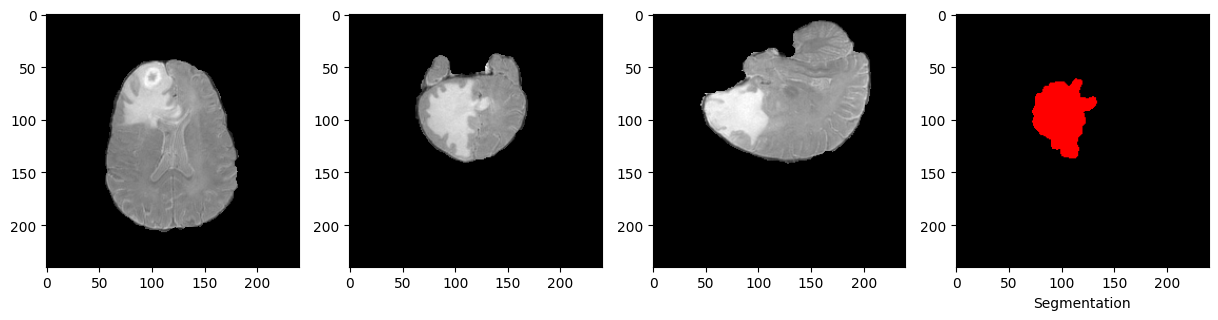

In [12]:
dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env"
load_dotenv(dotenv_path)


INPUT_PATH = os.getenv("INPUT_DATA_DIR")
PROCESSED_PATH = os.getenv('PROCESSED_DATA_DIR')
INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])

TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

TAR_PATH = os.path.join(INPUT_PATH_PARENT,'BraTS2021_Training_Data.tar')
BUILD_DATASET = False

if(BUILD_DATASET):
  untar_brats(tar_path = '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar', extract_path = INPUT_PATH )
  dataset = DataPreprocessor()
  dataset.split_dataset()

dataset = DataPreprocessor()
train_loader = DataLoader(dataset, sampler = SeqSampler(dataset), batch_size = 1, num_workers = 0)
images, labels= next(iter(train_loader))
plot_brain_sections([images[0], labels[0]])
del images, labels, train_loader, dataset

## Train and predict ⌛

In [13]:
torch.cuda.empty_cache()
batch_size = 2
num_epochs = 1
lr = 0.01
TRAIN_MODEL = False
LOAD_MODEL = False # resume training


# Directory with full dataset, split it
model = Autoencoder()

dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)
if(not os.path.exists(TRAIN_PATH)):
  dataset.split_dataset()


train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH, transform=True)
val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH,  transform=True)
test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH,  transform=True)

train_loader = DataLoader(dataset = train_dataset,
                         sampler = SeqSampler(train_dataset),
                         batch_size = batch_size,
                         num_workers = 0)

val_loader = DataLoader(dataset = val_dataset,
                         sampler = SeqSampler(val_dataset),
                         batch_size = batch_size,
                         num_workers = 0)

test_loader = DataLoader(dataset = test_dataset,
                         sampler = SeqSampler(test_dataset),
                         batch_size = batch_size,
                         num_workers = 0)

wrapper = ModelWrapper(model = model,
                       loss_fn = nn.L1Loss(),
                       optimizer = torch.optim.Adam(model.parameters(), lr=lr),
                       num_epochs = num_epochs,
                       LOAD_MODEL = LOAD_MODEL
                       )

print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

if(TRAIN_MODEL):
    training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = val_loader )
    torch.cuda.empty_cache()
torch.cuda.empty_cache()


Elapsed epochs: 0


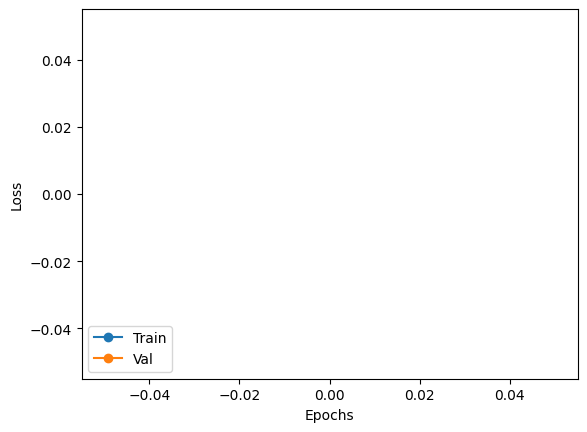

In [14]:
xx = range(1,wrapper.elapsed_epochs+1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(xx, wrapper.training_loss, '-o', label = 'Train')
plt.plot(xx, wrapper.validation_loss,'-o', label = 'Val')
plt.legend(loc='lower left')

In [15]:
if(TRAIN_MODEL or LOAD_MODEL):
  im_test, lab = next(iter(test_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  slice_index = 100
  ax = 0
  f, ax_array = plt.subplots(1,2, figsize=(10,10))
  ax_array[0].imshow((np.sum(im_test.cpu().detach().numpy()[0], axis=0)[slice_index,:,:]), cmap='gray')
  ax_array[1].imshow((np.sum(out_numpy, axis=0)[slice_index,:,:]), cmap='gray')
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

### TO-DO ✅



#### FIX 🧯

- Actually the wrapper works only with unsupervised models because i'm not considering the labels in the training, evaluation and prediciton for simplicity.

- The net is learning a black image probably because there is a great amount of black  pixels. Use another activation function such as Tanh?

#### ERRORS 🔴

#### 1
ERROR Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

batch_size = 1
num_epochs = 2
lr = 0.05
TRAIN_MODEL =  True
LOAD_MODEL = True # resume training


Answer: it depends on load_model method, probably not sending model.to(device) when loading it.

Il problema era nel caricamento di un vecchio modello, eliminandolo fuziona tutto

#### 2

Quando carico il modello e lo riaddestro, nel momento un cui effettua una predizione il risultato è tutto nero.

ACTION: Ho eliminato il layer sigmoid dal decoder e ho modificato la loss da MSE a L1

Quando l'immagine è nera la loss rimane uguale nelle diverse epoche.

Penso che la sigmoid combinata con la MSELoss porti i valori dell'immagine a zero.



#### 3

2 epocha di trianing al 4 step di 750 no such file or no access BraTS2021_00709_flair.nii.gz e poi list out of range generato dall'istruzione images[0] all'interno di __ getitem __

Infatti train_loader.dataset.all_ids[4] è uguale a 00709



Action: inserire un continue all'interno del train loop nel caso in cui l'immagine caricata sia vuota. L'immagine vuota (tutti zero) verrà restituita da getitem nel caso in cui il file non viene trovato.

PROBLEM: in un'ottica di batch questo farebbe scartare un'intera batch. Bisognerebbe sostituire all'immagine vuota una di quelle presenti nel batch. È una soluzione che va implementata solo in casi estremi




# TESTING SECTION 🚧

In [16]:
TEST_MODE = True

torch.cuda.empty_cache()
if(TEST_MODE):

  INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'
  INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])

  TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
  VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
  TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

  torch.cuda.empty_cache()
  batch_size = 1
  num_epochs = 10
  lr = 0.005
  TRAIN_MODEL = True
  LOAD_MODEL = False # resume training


  # Directory with full dataset, split it
  model = Autoencoder_simple()

  dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)
  if(not os.path.exists(TRAIN_PATH)):
    dataset.split_dataset()


  train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH)
  val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH)
  test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH)

  train_loader = DataLoader(dataset = train_dataset,
                           sampler = SeqSampler(train_dataset),
                           batch_size = batch_size,
                           num_workers = 0)

  val_loader = DataLoader(dataset = val_dataset,
                           sampler = SeqSampler(val_dataset),
                           batch_size = batch_size,
                           num_workers = 0)

  test_loader = DataLoader(dataset = test_dataset,
                           sampler = SeqSampler(test_dataset),
                           batch_size = batch_size,
                           num_workers = 0)

  wrapper = ModelWrapper(model = model,
                         loss_fn = nn.MSELoss(),
                         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3),
                         num_epochs = num_epochs,
                         LOAD_MODEL = LOAD_MODEL
                         )

  print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

  if(TRAIN_MODEL):
      training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = val_loader )
      torch.cuda.empty_cache()




Elapsed epochs: 0
Epoch: 1/10, Step: 12/12, Loss: 0.0033, Elapsed time: 40 sec 
Epoch: 1/10, Loss: 0.0073, Epoch elapsed time: 40 sec 

Epoch: 1/10, Validation Step: 4/4, Validation Loss: 0.0095, Elapsed time: 58 sec Epoch: 1/10, Validation Step: 4/4, Validation Loss: 0.0072, Elapsed time: 58 sec 
Epoch: 2/10, Step: 12/12, Loss: 0.0020, Elapsed time: 85 sec 
Epoch: 2/10, Loss: 0.0028, Epoch elapsed time: 28 sec 

Epoch: 2/10, Validation Step: 4/4, Validation Loss: 0.0117, Elapsed time: 103 sec Epoch: 2/10, Validation Step: 4/4, Validation Loss: 0.0088, Elapsed time: 46 sec 
Epoch: 3/10, Step: 12/12, Loss: 0.0017, Elapsed time: 131 sec 
Epoch: 3/10, Loss: 0.0023, Epoch elapsed time: 28 sec 

Epoch: 3/10, Validation Step: 4/4, Validation Loss: 0.0101, Elapsed time: 149 sec Epoch: 3/10, Validation Step: 4/4, Validation Loss: 0.0077, Elapsed time: 46 sec 
Epoch: 4/10, Step: 12/12, Loss: 0.0019, Elapsed time: 177 sec 
Epoch: 4/10, Loss: 0.0021, Epoch elapsed time: 28 sec 

Epoch: 4/10, Vali

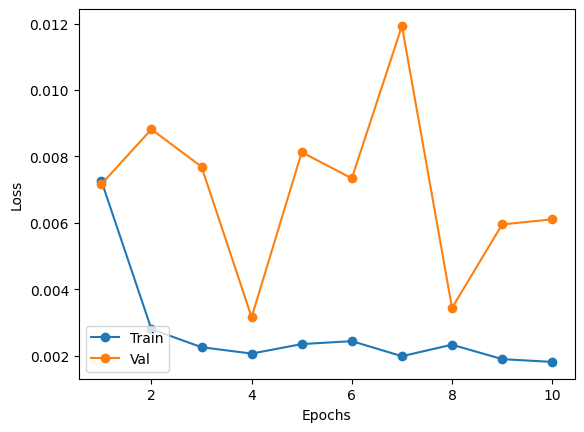

In [17]:
xx = range(1,wrapper.elapsed_epochs+1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(xx, wrapper.training_loss, '-o', label = 'Train')
plt.plot(xx, wrapper.validation_loss,'-o', label = 'Val')
plt.legend(loc='lower left')

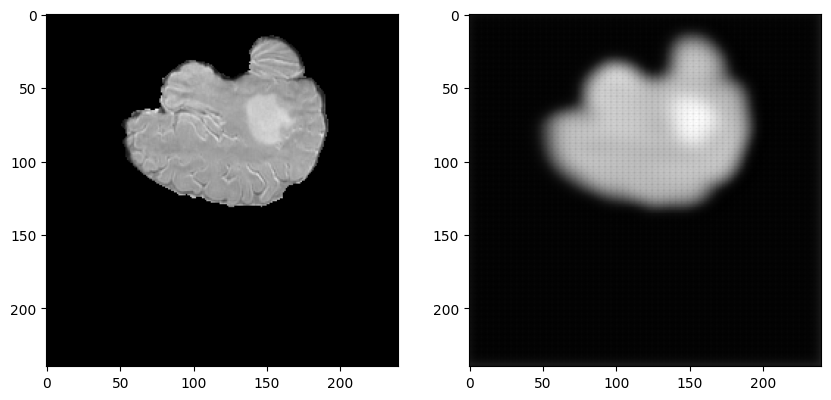

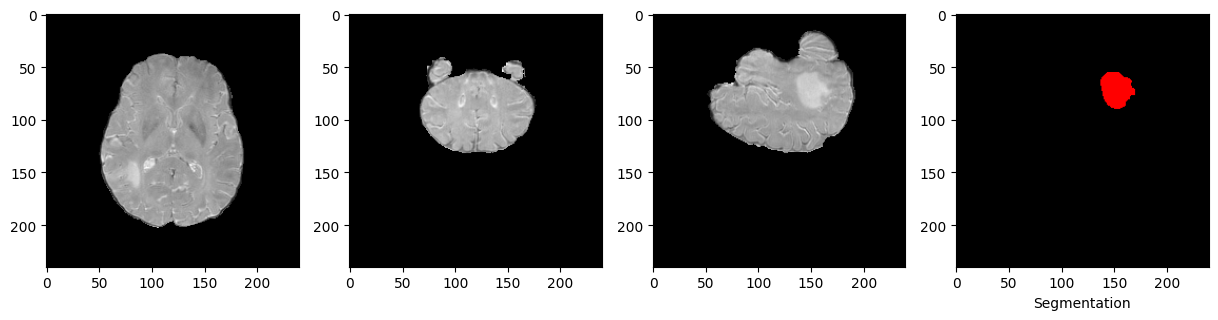

In [18]:
if(TRAIN_MODEL or LOAD_MODEL):
  im_test, lab = next(iter(test_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  slice_index = 80
  ax = 2
  f, ax_array = plt.subplots(1,2, figsize=(10,10))
  ax_array[0].imshow((np.sum(im_test.cpu().detach().numpy()[0], axis=0)[:,:,slice_index]), cmap='gray')
  ax_array[1].imshow((np.sum(out_numpy, axis=0)[:,:,slice_index]), cmap='gray')
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

## Filters visualization

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().permute((1, 2, 0)))



In [20]:
#ker = wrapper.model.decoder.deconv4[0].weight.detach().clone()
#print(ker.size())
#
#visTensor(torch.sum(ker, dim=(0)), allkernels=True)

In [21]:
#import torchvision
#kernels =  ker[2]
#kernels = kernels - kernels.min()
#kernels = kernels / kernels.max()
#filter_img = torchvision.utils.make_grid(kernels, nrow = 10)
#
## change ordering since matplotlib requires images to
## be (H, W, C)
#plt.imshow(filter_img.cpu().permute(1, 2, 0).flatten(1))

### Successful models (?)


In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        slope = 0.5
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(16, 32 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 64 , kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=slope),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.LeakyReLU(negative_slope=slope),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1, padding=1,),
            nn.LeakyReLU(negative_slope=slope),
            nn.ConvTranspose3d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.Sigmoid()  # Output between 0 and 1 for image data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
